# InSAR denoiser training, validation

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
import random
from scipy import stats

## Dataset construction

In [2]:
# set paths
main_dir = '/home/jovyan/InSAR_denoising_CNN'
train_signal_dir = f'{main_dir}/train_subsets_v3/veloc/'
train_noise_dir = f'{main_dir}/train_subsets_v3/int/'
train_dem_dir = f'{main_dir}/train_subsets_v3/dem/'
train_era5_dir = f'{main_dir}/train_subsets_v3/era5/'

val_signal_dir = f'{main_dir}/val_subsets_v3/veloc/'
val_noise_dir = f'{main_dir}/val_subsets_v3/int/'
val_dem_dir = f'{main_dir}/val_subsets_v3/dem/'
val_era5_dir = f'{main_dir}/val_subsets_v3/era5/'

# list files
train_signal_fns = os.listdir(train_signal_dir)
train_noise_fns = os.listdir(train_noise_dir)
train_dem_fns = os.listdir(train_dem_dir)
train_era5_fns = os.listdir(train_era5_dir)

val_signal_fns = os.listdir(val_signal_dir)
val_noise_fns = os.listdir(val_noise_dir)
val_dem_fns = os.listdir(val_dem_dir)
val_era5_fns = os.listdir(val_era5_dir)

# exclude non tif files, e.g. metadata
def list_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list

train_signal_list = list_tifs(train_signal_fns)
train_noise_list = list_tifs(train_noise_fns)
train_dem_list = list_tifs(train_dem_fns)
train_era5_list = list_tifs(train_era5_fns)

val_signal_list = list_tifs(val_signal_fns)
val_noise_list = list_tifs(val_noise_fns)
val_dem_list = list_tifs(val_dem_fns)
val_era5_list = list_tifs(val_era5_fns)

# create training list of only scenes shared in all necessary dirs
train_list = []
for fn in train_signal_list:
    if fn in train_noise_list and fn in train_dem_list and fn in train_era5_list:
        train_list.append(fn)
        
val_list = []
for fn in val_signal_list:
    if fn in val_noise_list and fn in val_dem_list and fn in val_era5_list:
        val_list.append(fn)

In [3]:
# define transforms
my_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, signal_dir, noise_dir, dem_dir, era5_dir, transform=None, 
                 norm=True, center=True, blurnoise=False, flip=False):
        self.file_list = file_list
        self.transform = transform
        self.signal_dir = signal_dir
        self.noise_dir = noise_dir
        self.dem_dir = dem_dir
        self.era5_dir = era5_dir
        self.norm = norm
        self.center = center
        self.blurnoise = blurnoise
        self.flip = flip
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        signal_path = self.signal_dir+self.file_list[idx]
        noise_path = self.noise_dir+self.file_list[idx]
        dem_path = self.dem_dir+self.file_list[idx]
        era5_path = self.era5_dir+self.file_list[idx]
        
        signal = self.transform(Image.open(signal_path))
        noise = self.transform(Image.open(noise_path))
        dem = self.transform(Image.open(dem_path))
        era5 = self.transform(Image.open(era5_path))
        
        # Generate era5 noise estimates
        era5 = era5*(0.05546576/12.5663706) # convert phase to displacement
        era5 = (noise-(era5*-1)) 
        
        # Blur noise
        if self.blurnoise == True: # blur noise to mitigate noise from non atmospheric sources
            gblur = transforms.GaussianBlur(kernel_size=(7, 7), sigma=5)
            noise = gblur(noise)
        
        # Generate scaled training images
        scalar = np.round(np.random.lognormal(-1.5, 1.5), 3) # FOR PLOTTING: 0.2, 0.7
        signal = signal*scalar*-1 #multiply by -1 because mintpy has a reversed sign convention
        train = noise+signal
        
        # Set era reference point
        ref_index = signal.abs().argmin().item() # location of lowest signal in velocity map
        corr_diff = (train.flatten()[ref_index] - era5.flatten()[ref_index]).item()
        era5 = era5+corr_diff 
        
        # correct train
        era5_corr = train-era5 #produce era5 corrected train image
        
        # correct hp
        hp_filter = transforms.GaussianBlur(kernel_size=(25, 25), sigma=15)
        train_filtered = hp_filter(train)
        hp_corr = train - train_filtered
        
        # normalization between -1 and 1 as in Zhao et al. https://doi.org/10.1016/j.isprsjprs.2021.08.009
        if self.norm == True:
            if train.min() < signal.min():
                norm_min = train.min()
            else:
                norm_min = signal.min()
                
            if train.max() > signal.max():
                norm_max = train.max()
            else:
                norm_max = signal.max()
            
            signal = 2*(((signal-norm_min)/(norm_max-norm_min)))-1
            noise  = 2*(((noise-(noise.min()))/(noise.max()-(noise.min()))))-1
            dem = 2*(((dem-dem.min())/(dem.max()-dem.min())))-1
            train = 2*(((train-norm_min)/(norm_max-norm_min)))-1
            era5 = 2*(((era5-norm_min)/(norm_max-norm_min)))-1
            era5_corr = 2*(((era5_corr-norm_min)/(norm_max-norm_min)))-1
            hp_corr = 2*(((hp_corr-norm_min)/(norm_max-norm_min)))-1
        
        if self.center == True: # center target images on 0 
            center_median = signal.median()
            train = train-center_median
            signal = signal-center_median
            era5_corr = era5_corr-center_median
            hp_corr = hp_corr-center_median
        
        if self.flip==True:
            flip_dim = []
            if random.random() < 0.25:
                flip_dim = [0]
            elif random.random() > 0.25 and random.random() < 0.5:
                flip_dim = [1]
            elif random.random() > 0.5 and random.random() < 0.75:
                flip_dim = [0, 1]
            train = torch.flip(train, flip_dim)
            signal = torch.flip(signal, flip_dim)
            noise = torch.flip(noise, flip_dim)
            era5 = torch.flip(era5, flip_dim)
            dem = torch.flip(dem, flip_dim)
            era5_corr = torch.flip(era5_corr, flip_dim)
            hp_corr = torch.flip(hp_corr, flip_dim)
         
        return train, signal, noise, era5, dem, era5_corr, hp_corr

In [5]:
# create dataloaders
train_data = dataset(train_list, train_signal_dir, train_noise_dir, train_dem_dir, train_era5_dir, transform=my_transforms, blurnoise=True, flip=True)
val_data = dataset(val_list, val_signal_dir, val_noise_dir, val_dem_dir, val_era5_dir, transform=my_transforms, blurnoise=True, flip=True)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=False)

## Examine dataset

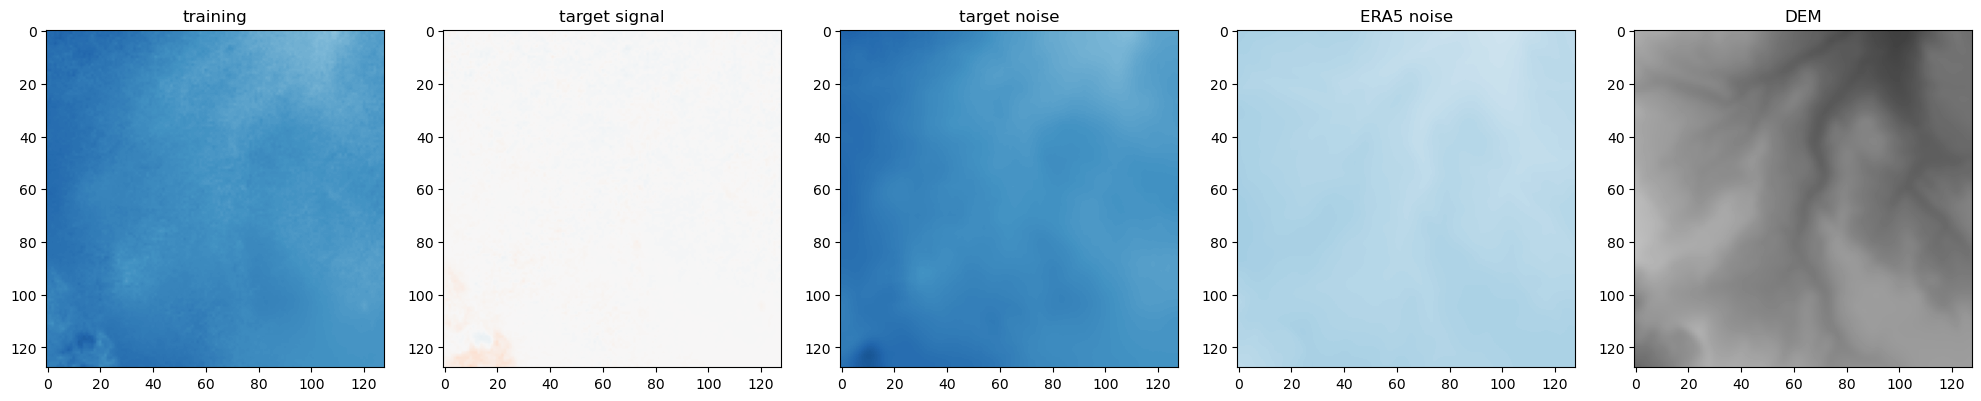

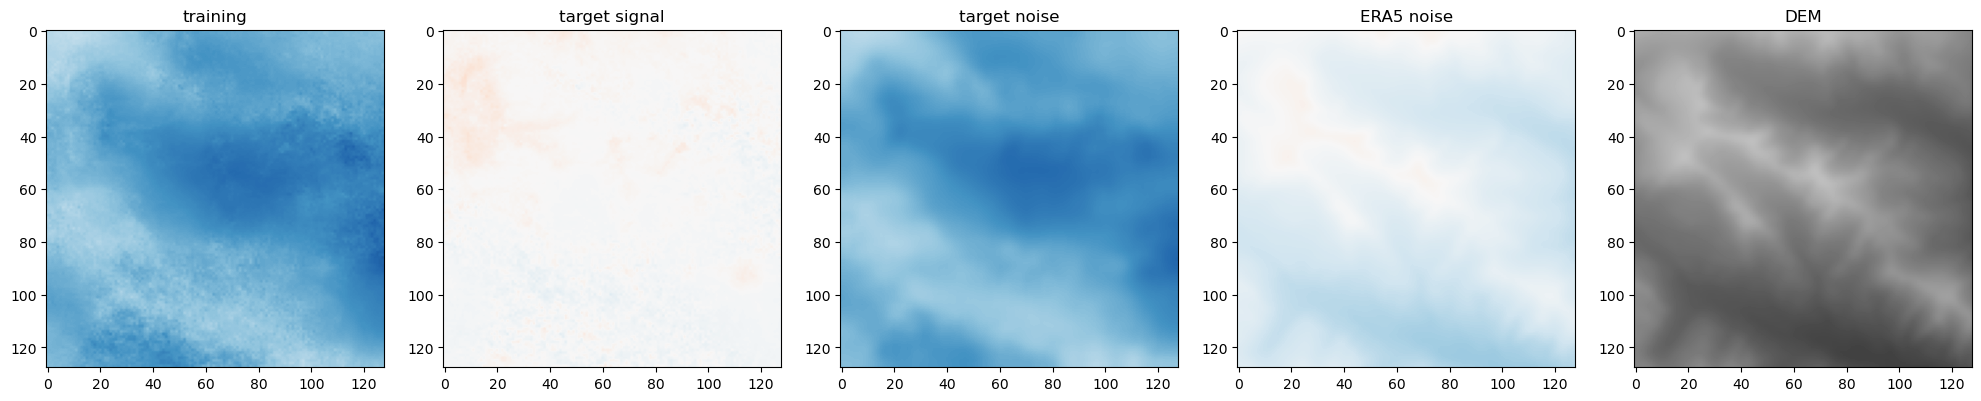

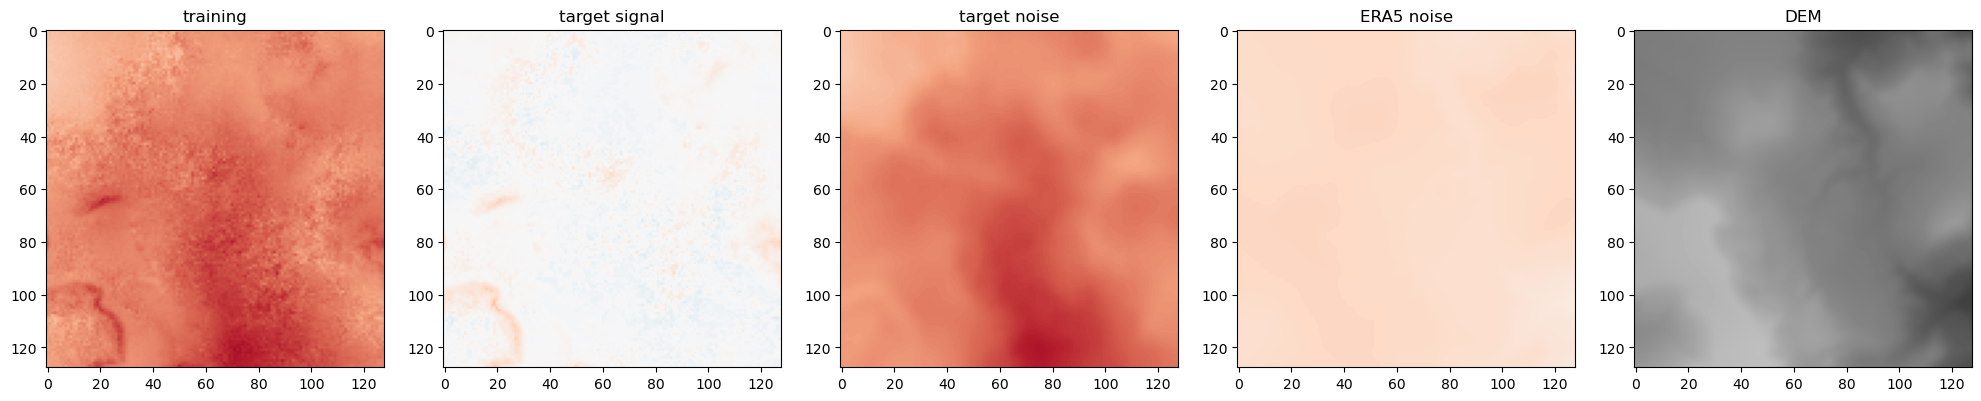

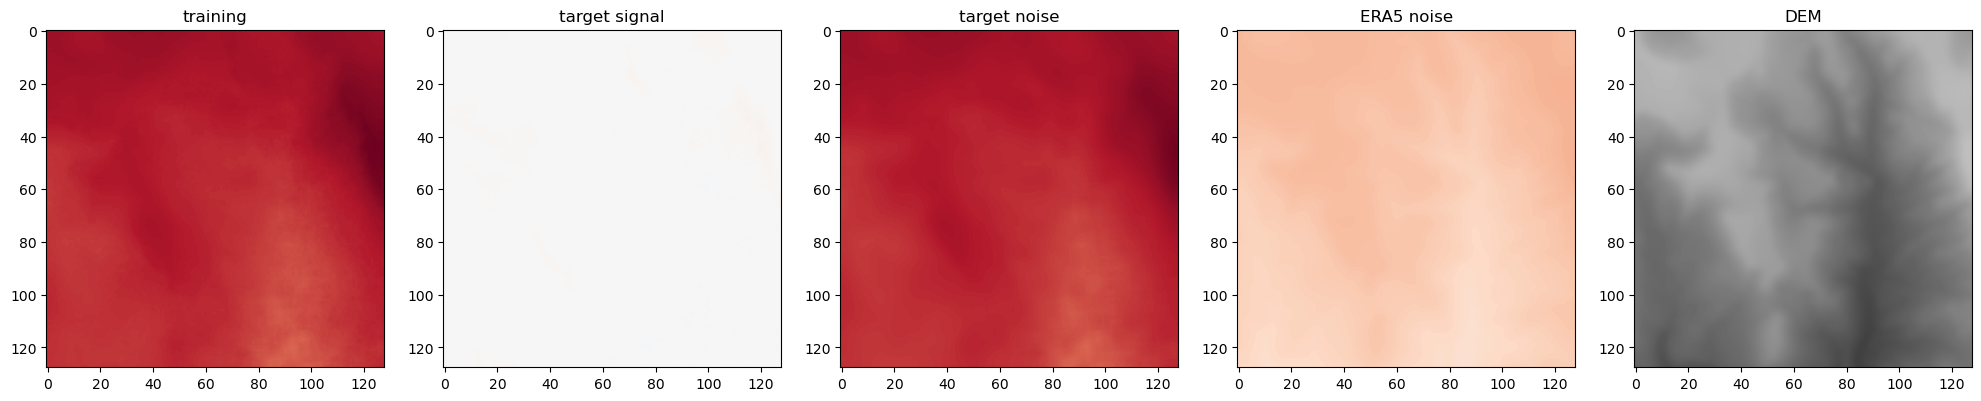

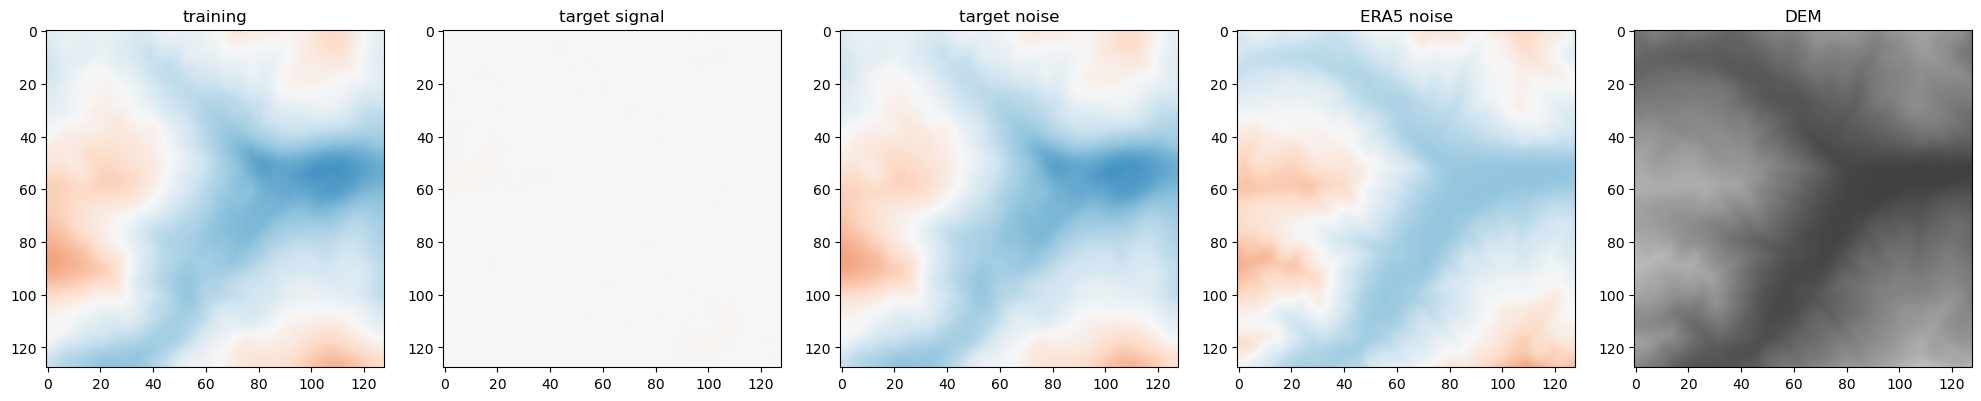

In [6]:
num_images = 5

for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(val_loader):
    if i < num_images:
            f, ax = plt.subplots(1, 5, figsize=(20,7))
            ax[0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2) 
            ax[0].set_title('training')
            ax[1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1].set_title('target signal')
            ax[2].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[2].set_title('target noise')
            ax[3].imshow(era5_noise.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[3].set_title('ERA5 noise')
            ax[4].imshow(dem.squeeze(), cmap='gray', vmin=-2, vmax=2)
            ax[4].set_title('DEM')
            f.tight_layout()
            
            #f, ax = plt.subplots(1, 5, figsize=(15,3))
            #ax[0].hist(sum(sum(sum(sample.tolist(), []), []), []), bins=40)
            #ax[1].hist(sum(sum(sum(signal_target.tolist(), []), []), []), bins=40)
            #ax[2].hist(sum(sum(sum((sample-signal_target).tolist(), []), []), []), bins=40)
            #ax[3].hist(sum(sum(sum(era5_noise.tolist(), []), []), []), bins=40)
            #ax[4].hist(sum(sum(sum(dem.tolist(), []), []), []), bins=40)
            #f.tight_layout()
            plt.savefig(f'input{i}.png', dpi=300)

## Define network

In [6]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=bias)


def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)


def check_valid_activation(choice):
    if choice not in ['relu', 'lrelu', 'prelu']:
        raise ValueError(f"'{choice}' is not a valid activation function. Choose among ['relu', 'lrelu', 'prelu'].\n")


def upconv(in_channels, out_channels, mode='transpose'):
    # stride=2 implies upsampling by a factor of 2
    get_up_mode = nn.ModuleDict([
        ['bilinear', nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2), conv1x1(in_channels, out_channels))],
        ['transpose', nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)]
    ])

    return get_up_mode[mode]


def get_activation(choice):
    activation_functions = nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['lrelu', nn.LeakyReLU(inplace=True)],
        ['prelu', nn.PReLU()]
        ])
    return activation_functions[choice]


def conv_block(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Partial encoder block consisting of a 3×3 convolutional layer with stride 1, followed by batch normalization
    (optional) and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


def conv_up_block(in_channels, out_channels, activation='relu', do_BN=True, up_mode='transpose', *args, **kwargs):
    """
    Decoder block consisting of an up-convolutional layer, followed by a 3×3 convolutional layer with stride 1,
    batch normalization (optional), and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                get_activation(activation))
            )
    else:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
                get_activation(activation))
            )


def bottleneck(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Bottleneck block.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


class SkipConnection(nn.Module):
    def __init__(self):
        super(SkipConnection, self).__init__()

    def forward(self, x_skip, x_up):
        return x_skip + x_up


class UNet(nn.Module):
    def __init__(self, n_input_channels=2, start_kernel=64, max_filter_depth=512, depth=5,
                 act_fn_encoder='relu', act_fn_decoder='relu', act_fn_bottleneck='relu', up_mode='transpose',
                 do_BN=True, bias_conv_layer=False, outer_skip=True, outer_skip_BN=False):
        """
        UNet network architecture.
        :param n_input_channels:    int, number of input channels
        :param start_kernel:        int, number of filters of the first convolutional layer in the encoder
        :param max_filter_depth:    int, maximum filter depth
        :param depth:               int, number of downsampling and upsampling layers (i.e., number of blocks in the
                                    encoder and decoder)
        :param act_fn_encoder:      str, activation function used in the encoder
        :param act_fn_decoder:      str, activation function used in the decoder
        :param act_fn_bottleneck:   str, activation function used in the bottleneck
        :param up_mode:             str, upsampling mode
        :param do_BN:               boolean, True to perform batch normalization after every convolutional layer,
                                    False otherwise
        :param bias_conv_layer:     boolean, True to activate the learnable bias of the convolutional layers,
                                    False otherwise
        :param outer_skip:          boolean, True to activate the long residual skip connection that adds the
                                    initial DSM to the output of the last decoder layer, False otherwise
        :param outer_skip_BN:       boolean, True to add batch normalization to the long residual skip connection,
                                    False otherwise
        """

        super(UNet, self).__init__()

        check_valid_activation(act_fn_encoder)
        check_valid_activation(act_fn_decoder)
        check_valid_activation(act_fn_bottleneck)

        if up_mode not in ['transpose', 'bilinear']:
            raise ValueError(f"'{up_mode}' is not a valid mode for upsampling. Choose among ['transpose', 'bilinear'] "
                             "to specify 'up_mode'.\n")

        self.n_input_channels = n_input_channels
        self.start_kernel = start_kernel
        self.depth = depth
        self.act_fn_encoder = act_fn_encoder
        self.act_fn_decoder = act_fn_decoder
        self.act_fn_bottleneck = act_fn_bottleneck
        self.up_mode = up_mode
        self.max_filter_depth = max_filter_depth
        self.do_BN = do_BN
        self.bias_conv_layer = bias_conv_layer
        self.do_outer_skip = outer_skip
        self.do_outer_skip_BN = outer_skip_BN
        self.filter_depths = [self.start_kernel * (2 ** i) for i in range(self.depth)]

        # Restrict the maximum filter depth to a predefined value
        self.filter_depths = [self.max_filter_depth if i > self.max_filter_depth else i for i in self.filter_depths]

        # Set up the encoder
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Sequential(
            conv_block(self.n_input_channels, self.start_kernel, activation=self.act_fn_encoder, do_BN=self.do_BN),
            nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        for in_channel, out_channel in zip(self.filter_depths, self.filter_depths[1:]):
            self.encoder.append(nn.Sequential(
                conv_block(in_channel, out_channel, activation=self.act_fn_encoder, do_BN=self.do_BN),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        # Set up the bottleneck
        self.bottleneck = bottleneck(self.filter_depths[-1], self.filter_depths[-1], activation=self.act_fn_bottleneck,
                                     do_BN=self.do_BN)

        # Set up the decoder
        self.decoder = nn.ModuleList()
        self.filter_depths_up = list(reversed(self.filter_depths))

        for in_channel, out_channel in zip(self.filter_depths_up[:-1], self.filter_depths_up[1:]):
            self.decoder.append(conv_up_block(in_channel, out_channel, activation=self.act_fn_decoder,
                                              up_mode=self.up_mode, do_BN=self.do_BN))
        self.decoder.append(upconv(self.filter_depths_up[-1], self.filter_depths_up[-1], up_mode))

        # Set up the final layer of the decoder
        self.last_layer = conv3x3(self.start_kernel, 1, bias=self.bias_conv_layer)

        # Skip connection
        self.skipconnect = SkipConnection()

        # Batch normalization added to the long residual skip connection
        if self.do_outer_skip:
            self.layer_outer_skip = nn.ModuleList()
            if self.do_outer_skip_BN:
                self.layer_outer_skip.append(nn.BatchNorm2d(1))
            self.layer_outer_skip.append(SkipConnection())

    def forward(self, x, dem):
        skip_connections = []
        x = torch.cat((x, dem), dim=1)
        out = x

        # Encoder (save intermediate outputs for skip connections)
        for index, layer in enumerate(self.encoder):
            layer_conv = layer[:-1]  # all layers before the pooling layer (at depth index)
            layer_pool = layer[-1]   # pooling layer (at depth index)

            out_before_pool = layer_conv(out)
            skip_connections.append(out_before_pool)
            out = layer_pool(out_before_pool)

        # Bottleneck
        out = self.bottleneck(out)

        # Decoder + skip connections
        index_max = len(self.decoder) - 1
        for index, layer in enumerate(self.decoder):
            if index <= index_max - 1:
                layer_upconv = layer[0]  # upconv layer
                layer_conv = layer[1::]  # all other layers (conv, batchnorm, activation)

                out_temp = layer_upconv(out)
                out = self.skipconnect(skip_connections[-1 - index], out_temp)
                out = layer_conv(out)
            else:
                out_temp = layer(out)   # upconv of last layer
                out = self.skipconnect(skip_connections[-1 - index], out_temp)

        # Last layer of the decoder
        out = self.last_layer(out)

        # Add long residual skip connection
        if self.do_outer_skip:
            if self.layer_outer_skip.__len__() == 2:
                # pipe input through a batch normalization layer before adding it to the output of the last
                # decoder layer
                bn = self.layer_outer_skip[0]
                x_0 = x[:, 0, :, :]       # use channel 0 only
                x_0 = x_0.unsqueeze(1)
                x = bn(x_0)

            # add (batchnorm) input to the output of the last decoder layer
            add = self.layer_outer_skip[-1]
            x_0 = x[:, 0, :, :]
            x_0 = x_0.unsqueeze(1)

            out = add(x_0, out)  # use channel 0 only

        return out

## Train model

In [7]:
#load previous model
model = UNet()
model.load_state_dict(torch.load('noisemodelv4.4_150epochs'))
model.to('cuda')
model.eval()

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU

In [ ]:
%%time

#Define optimizer
#model = UNet()
model.to('cuda') # run on gpu
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.02) # set learning rate
loss_fn   = nn.L1Loss() # MAE loss function, doesn't penalize outliers as much as MSE
epochs = 115
quantile = 0.9 # full loss computed for pixels with magnitude above this quantile 
stable_scalar = 1 # scalar for devaluing pixels with magnitude below quantile in loss calc
torch.autograd.set_detect_anomaly(True)

train_loss = []
val_loss = []

for epoch in range(epochs):
    print(f'\nstarting epoch {epoch+35}')
    epoch_loss=[]
    val_temp_loss = []
    
    #if epoch == 10:
        #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) # reduce loss as given epoch
    
    #loop through training data 
    for (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in train_loader:
        model.train()
        optimizer.zero_grad()
        out = torch.clamp(model(sample.to('cuda'), dem.to('cuda')), -1, 1) # Generate noise predictions
        
        # isolate high-signal areas for loss calculation
        # find quantile values for given batch of images
        q = signal_target.to('cuda').abs().flatten(1, 3).quantile(dim=1, q=quantile, keepdim=True) 
        # scale down target values in pixels with magnitude below quantile for loss calc
        signal_target_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                         signal_target.to('cuda'), signal_target.to('cuda')*stable_scalar)
        # calculate predicted signals 
        signal_pred = sample.to('cuda')-out.to('cuda')
        # scale down predicted signal values in pixels with magnitude below quantile for loss calc
        signal_pred_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                       signal_pred.to('cuda'), signal_pred.to('cuda')*stable_scalar)
        
        loss = loss_fn(signal_pred_high.to('cuda'), signal_target_high.to('cuda')) # calculate loss 
        epoch_loss.append(loss.item()) # add batch loss to epoch loss list
        
        loss.backward() #Propagate the gradients in backward pass
        optimizer.step() 

    train_loss.append(np.mean(epoch_loss))
    print(f'training loss: {np.mean(epoch_loss)}')
    
    # run model on validation data 
    for (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in val_loader:
        with torch.no_grad():
            model.eval()
            out = torch.clamp(model(sample.to('cuda'), dem.to('cuda')), -1, 1) #Generate predictions using the model
            
            # isolate high-signal areas for loss calculation
            q = signal_target.to('cuda').abs().flatten(1, 3).quantile(dim=1, q=quantile, keepdim=True)
            signal_target_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                         signal_target.to('cuda'), signal_target.to('cuda')*stable_scalar)   
            signal_pred = sample.to('cuda')-out.to('cuda')
            signal_pred_high = torch.where(signal_target.to('cuda').abs()>q.to('cuda')[:, None, None], 
                                       signal_pred.to('cuda'), signal_pred.to('cuda')*stable_scalar)
            
            loss = loss_fn(signal_pred_high.to('cuda'), signal_target_high.to('cuda')) #Loss/error
            val_temp_loss.append(loss.item())
    
    val_loss.append(np.mean(val_temp_loss))
    print(f'validation loss: {np.mean(val_temp_loss)}')
    
    if (epoch+1)%5 == 0: 
        # save model
        torch.save(model.state_dict(), f'noisemodelv4.4_{epoch+1+35}epochs')

## Examine results

In [ ]:
random.seed(10)

In [ ]:
#plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('L1 loss')
ax.set_title('Loss')
ax.legend()
plt.savefig('loss.png', dpi=300)

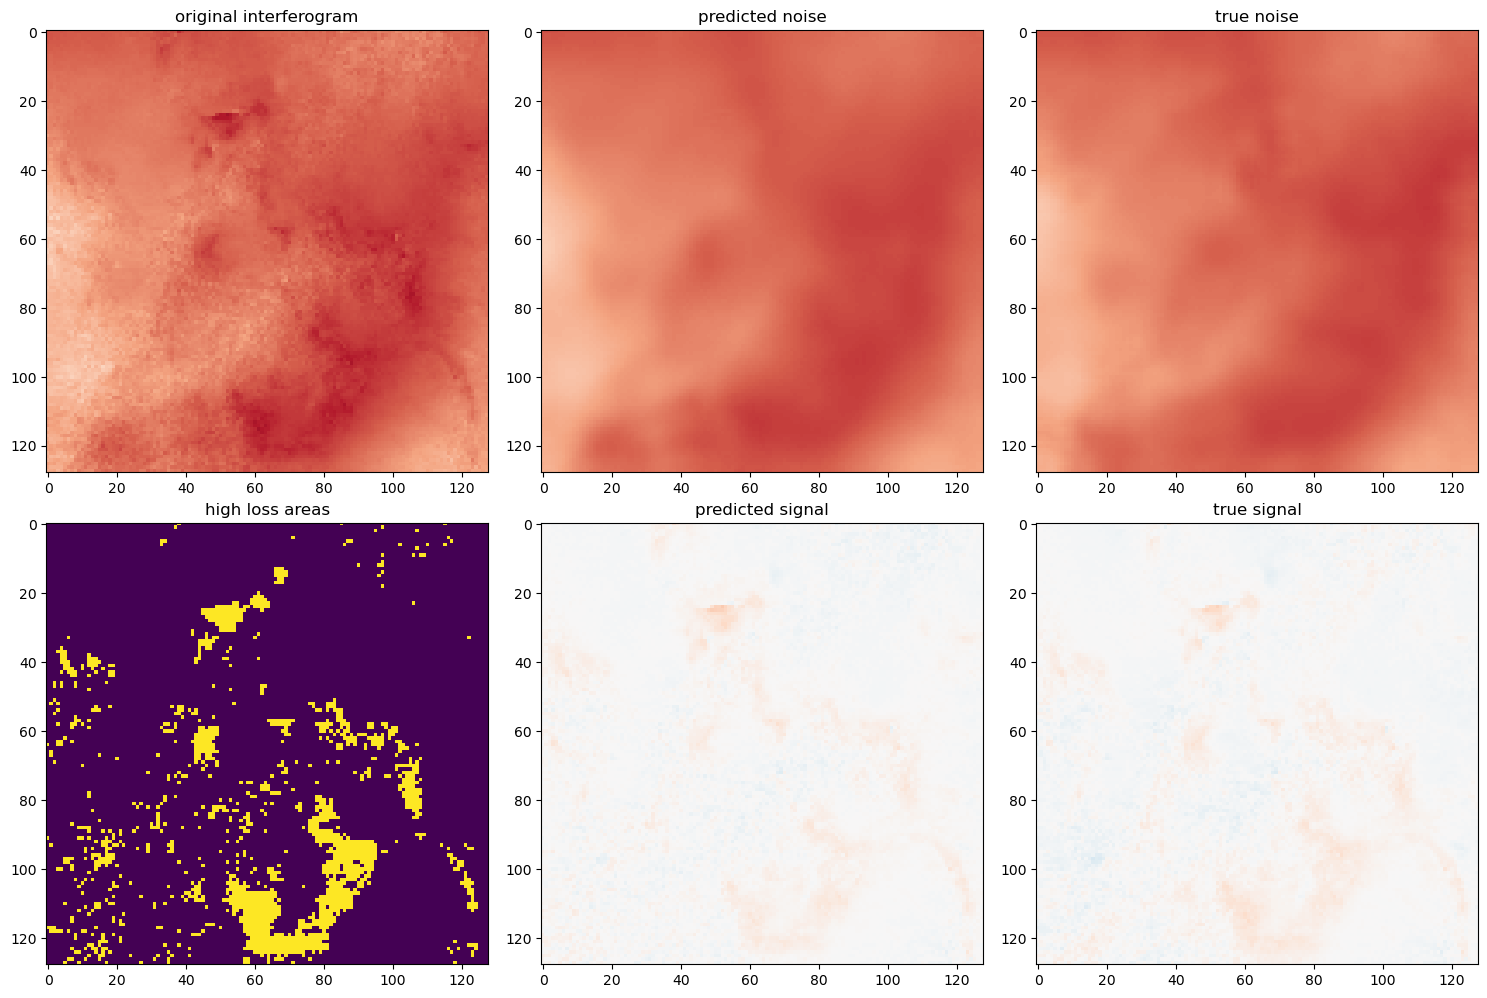

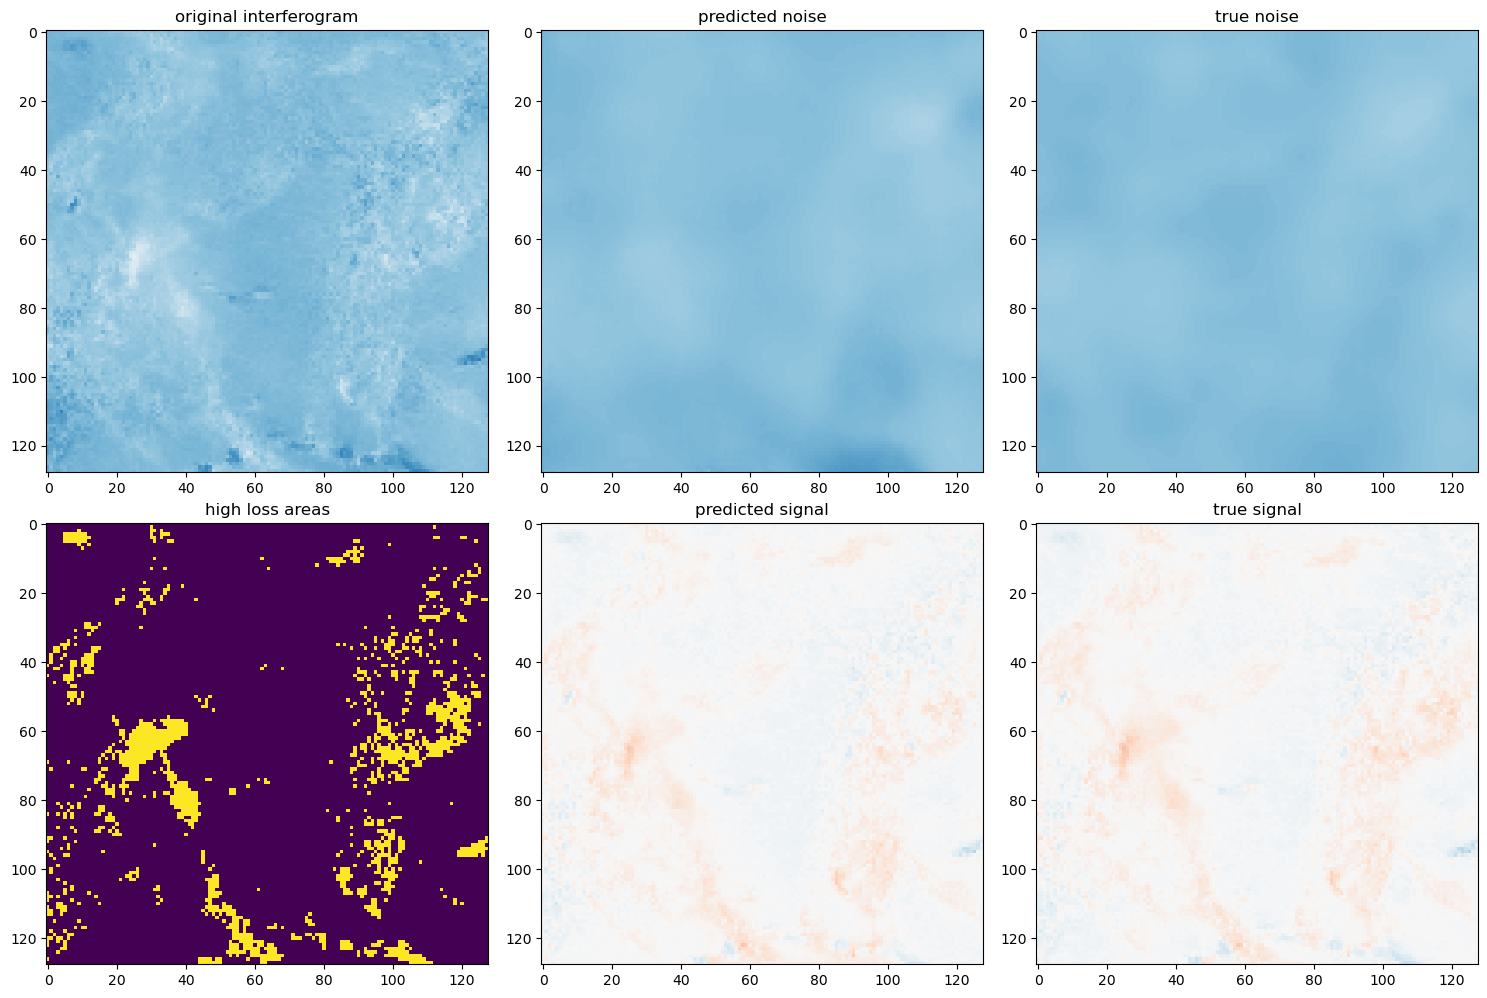

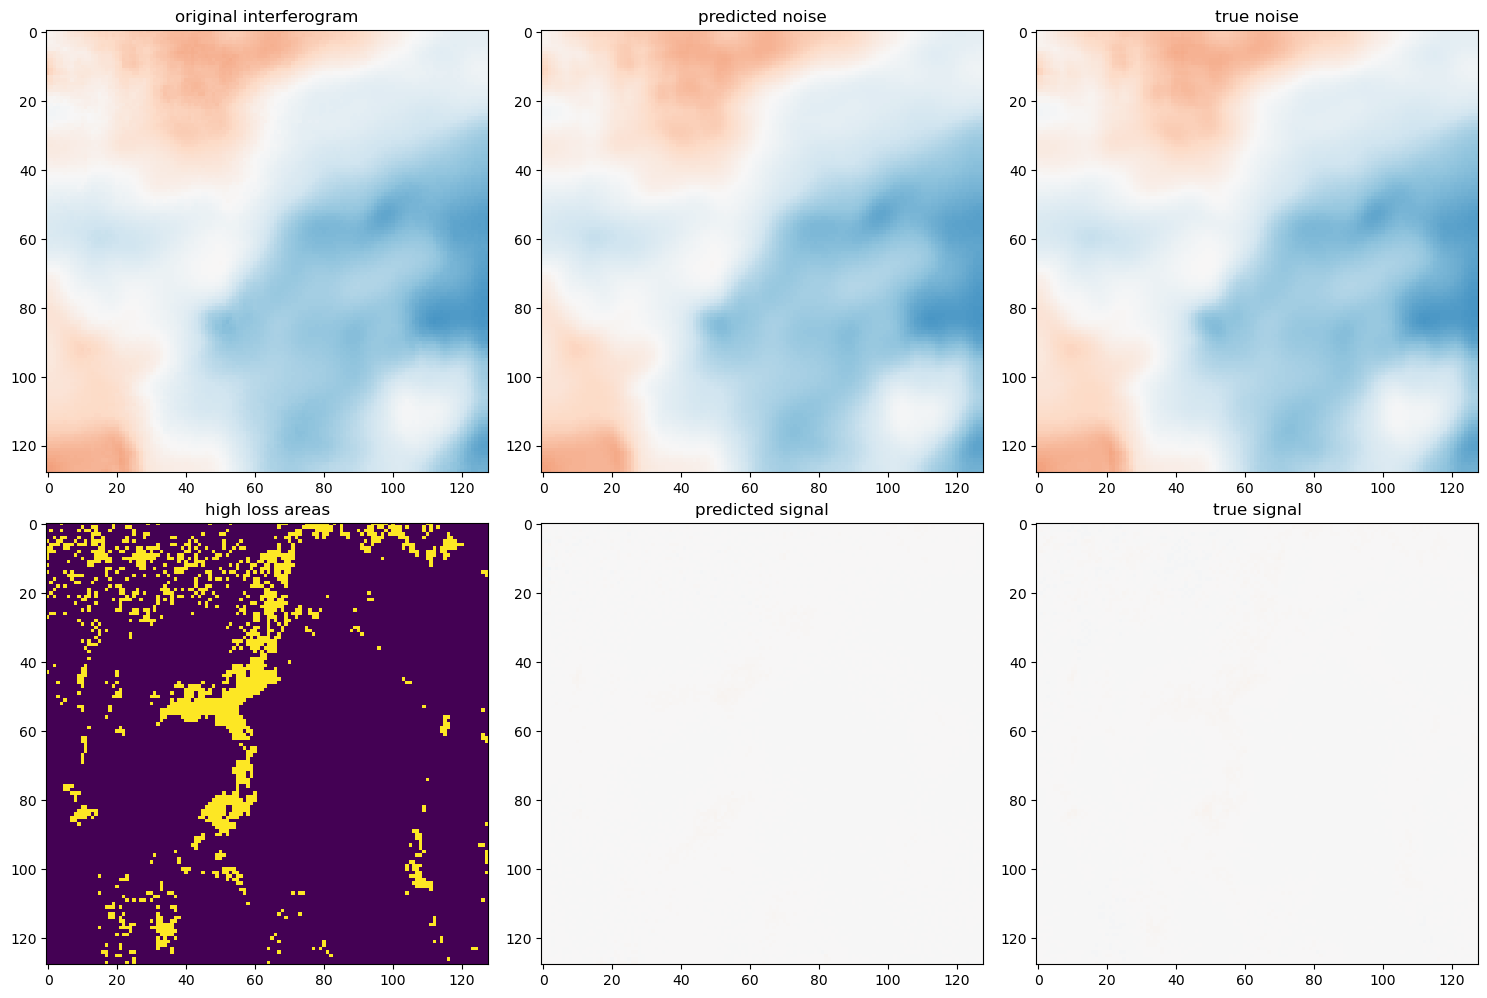

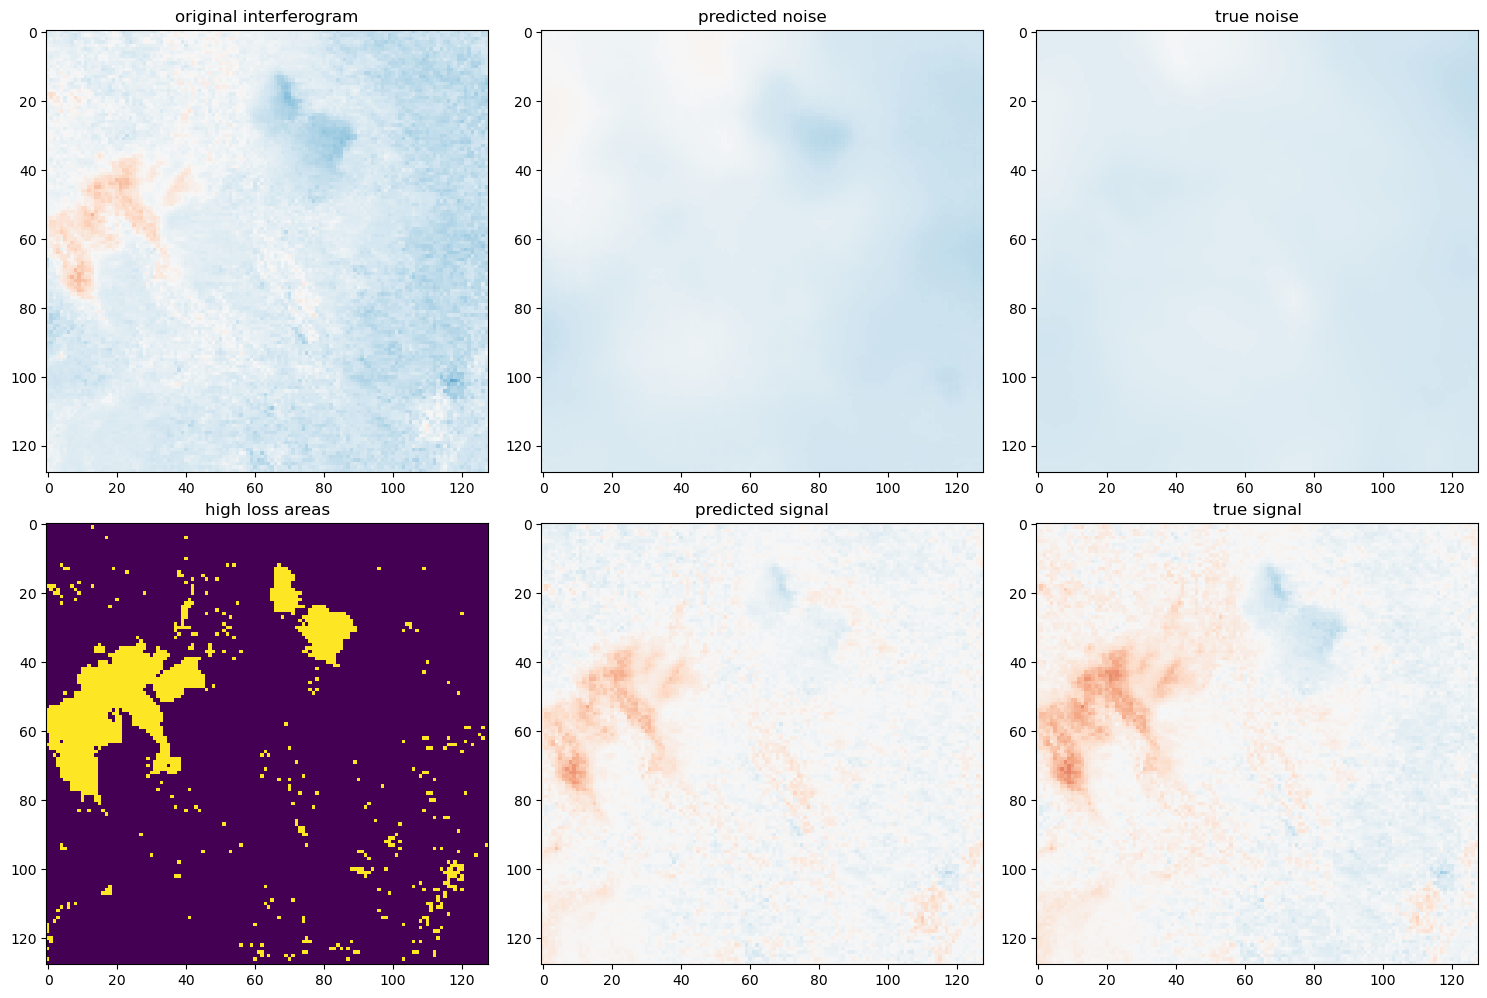

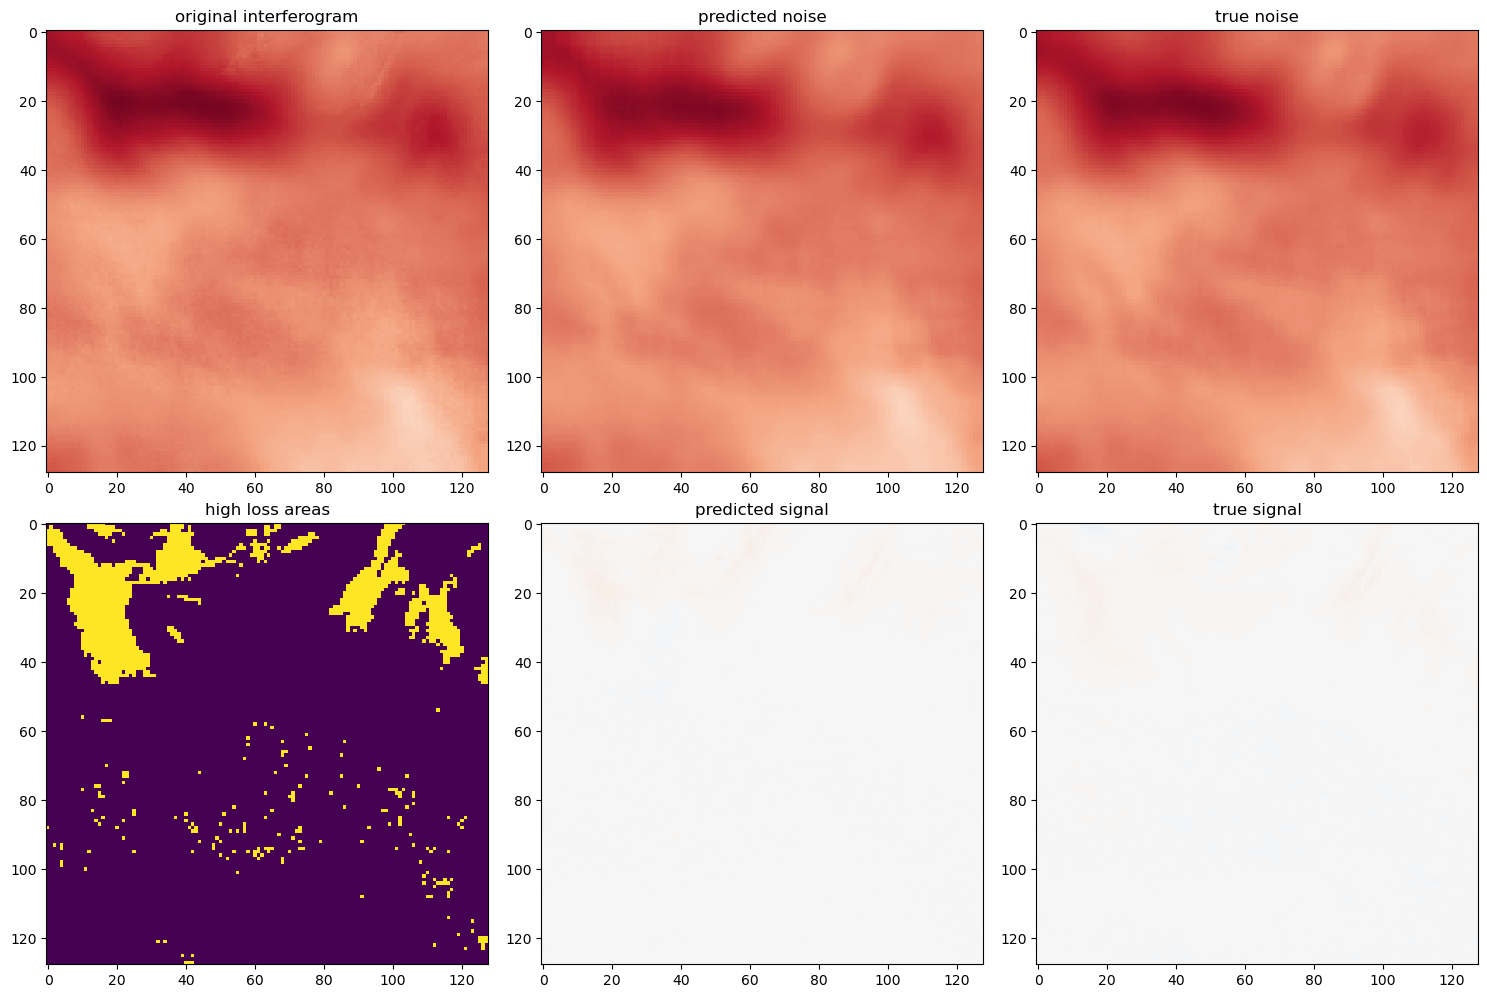

In [9]:
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True) #change batch size

num_images = 5
quantile = 0.90

for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            noise = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
            signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1)
            q = signal_target.to('cuda').abs().flatten(1, 3).quantile(dim=1, q=quantile, keepdim=True)
            signal_target_high = signal_target.to('cuda').abs()>q.to('cuda')[:, None, None]
            
            
            f, ax = plt.subplots(2, 3, figsize=(15,10))
            ax[0][0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2) 
            ax[0][0].set_title('original interferogram')
            ax[0][1].imshow(noise.squeeze().to('cpu'), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0][1].set_title('predicted noise')
            ax[0][2].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0][2].set_title('true noise')
            ax[1][1].imshow(signal.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1][1].set_title('predicted signal')
            ax[1][2].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1][2].set_title('true signal')
            ax[1][0].imshow(signal_target_high.squeeze().to('cpu'))
            ax[1][0].set_title('high loss areas')
            plt.tight_layout()
            plt.savefig(f'pred{i}.png', dpi=300)

## Correction comparison

In [8]:
val_data_ssim = dataset(val_list, val_signal_dir, val_noise_dir, val_dem_dir, val_era5_dir, transform=my_transforms, 
                        blurnoise=True)
train_data_ssim = dataset(train_list, train_signal_dir, train_noise_dir, train_dem_dir, train_era5_dir, transform=my_transforms, 
                        blurnoise=True)
val_loader_ssim = torch.utils.data.DataLoader(dataset = val_data_ssim, batch_size=1, shuffle=True)
train_loader_ssim = torch.utils.data.DataLoader(dataset = train_data_ssim, batch_size=1, shuffle=False)

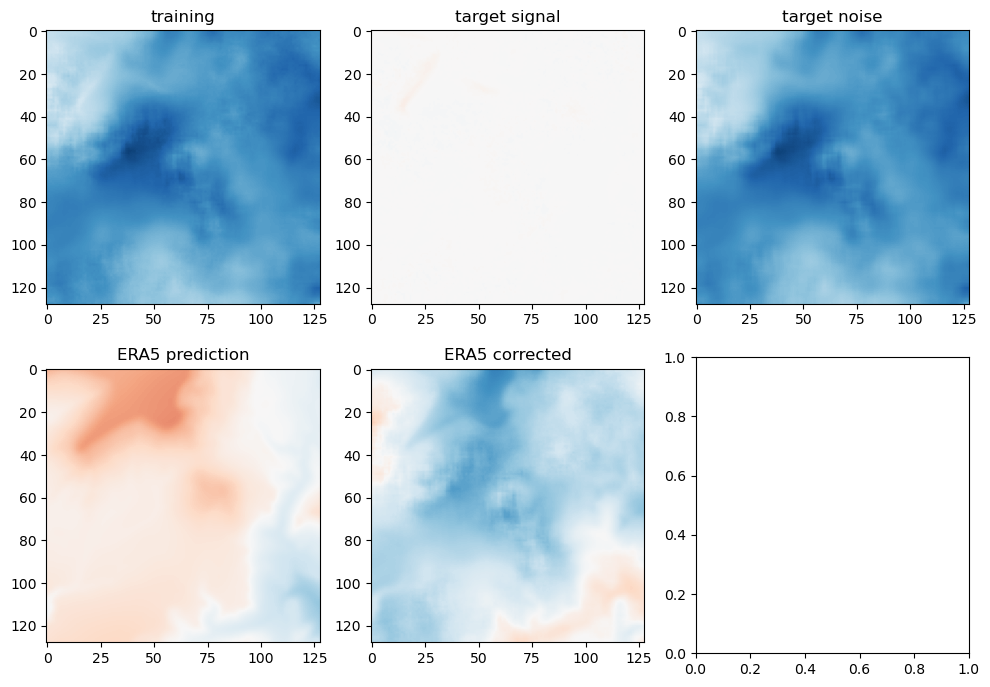

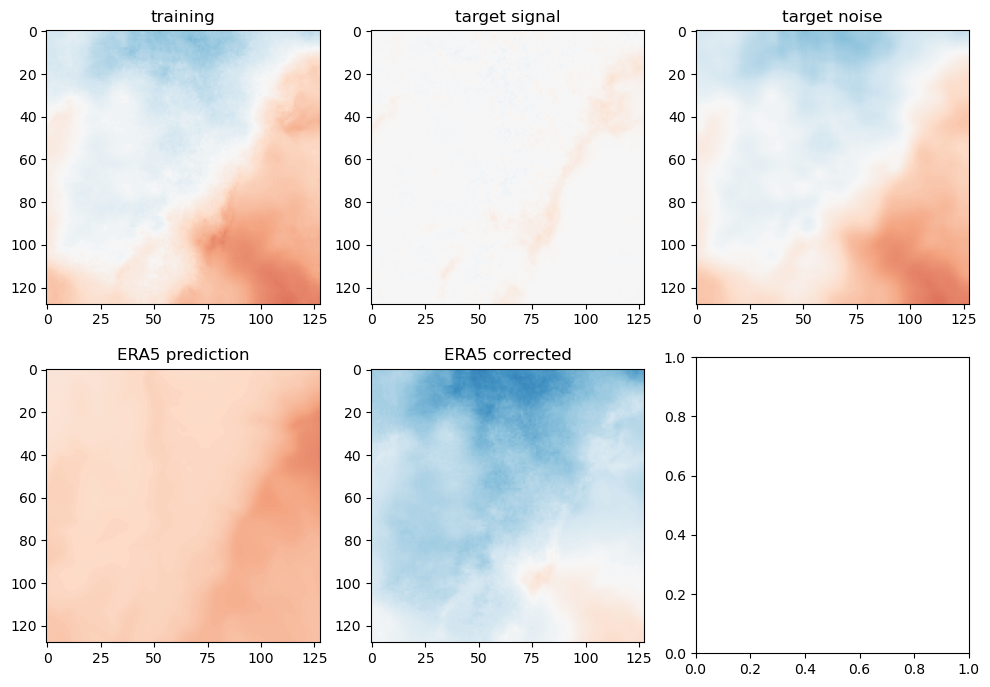

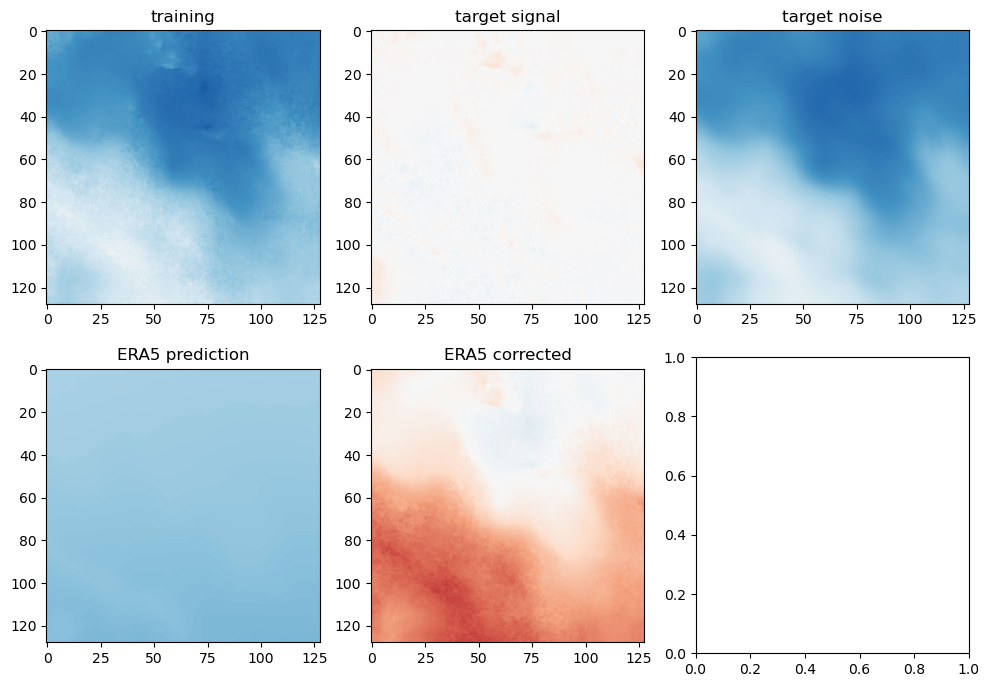

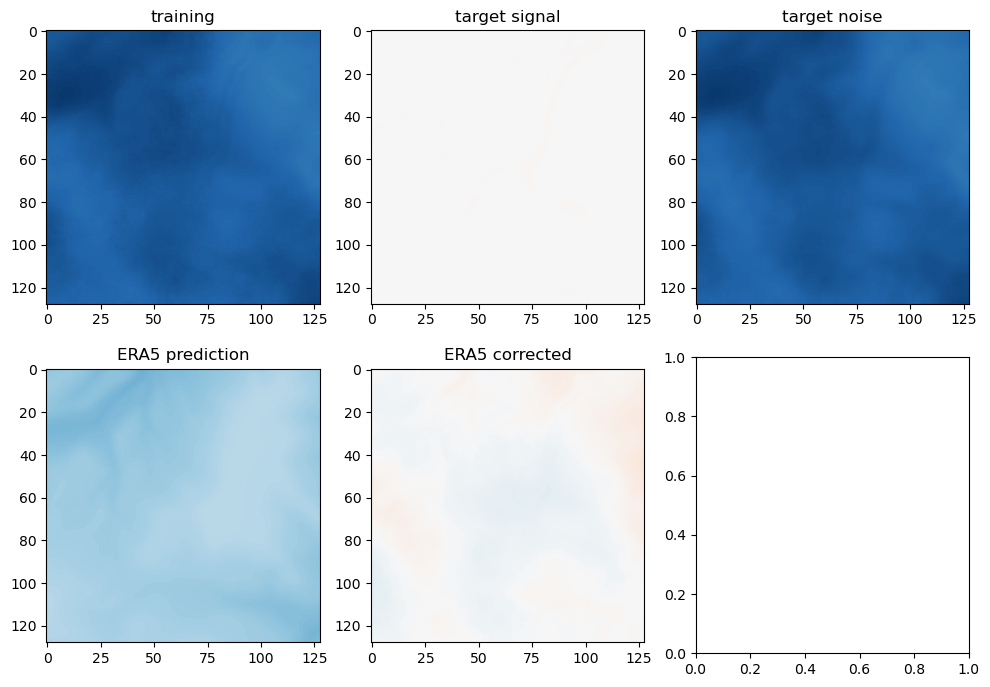

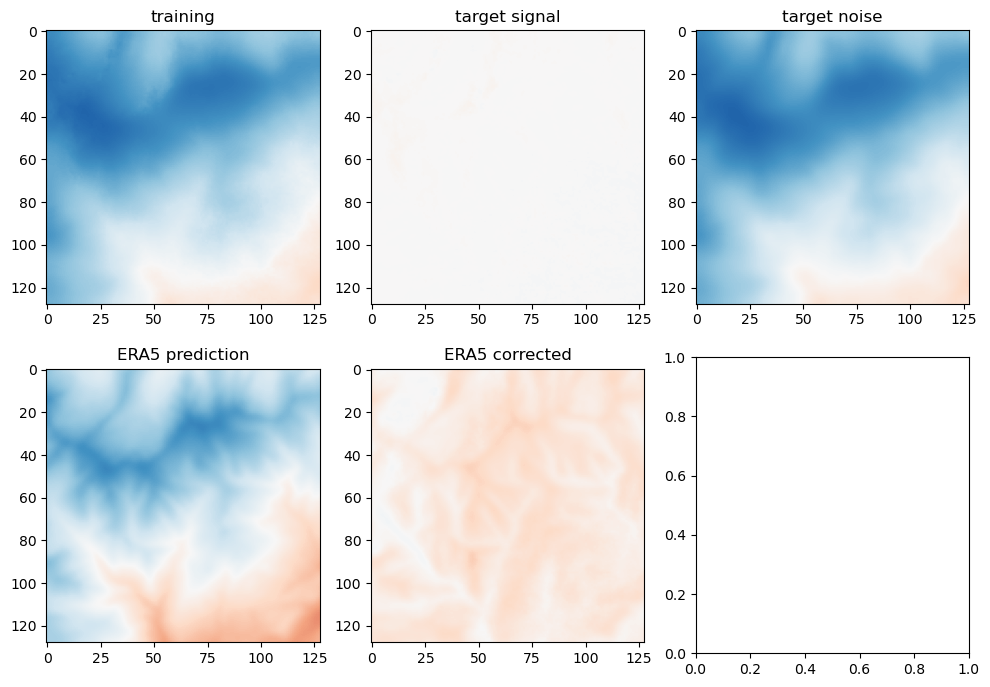

In [11]:
# visualize era5 correction only
num_images = 5

for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(val_loader_ssim):
    if i < num_images:
            f, ax = plt.subplots(2, 3, figsize=(10,7))
            ax[0, 0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2) 
            ax[0, 0].set_title('training')
            ax[0, 1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0, 1].set_title('target signal')
            ax[0, 2].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0, 2].set_title('target noise')
            
            ax[1, 0].imshow(era5_noise.detach().squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 0].set_title('ERA5 prediction')
            ax[1, 1].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 1].set_title('ERA5 corrected')
            f.tight_layout()

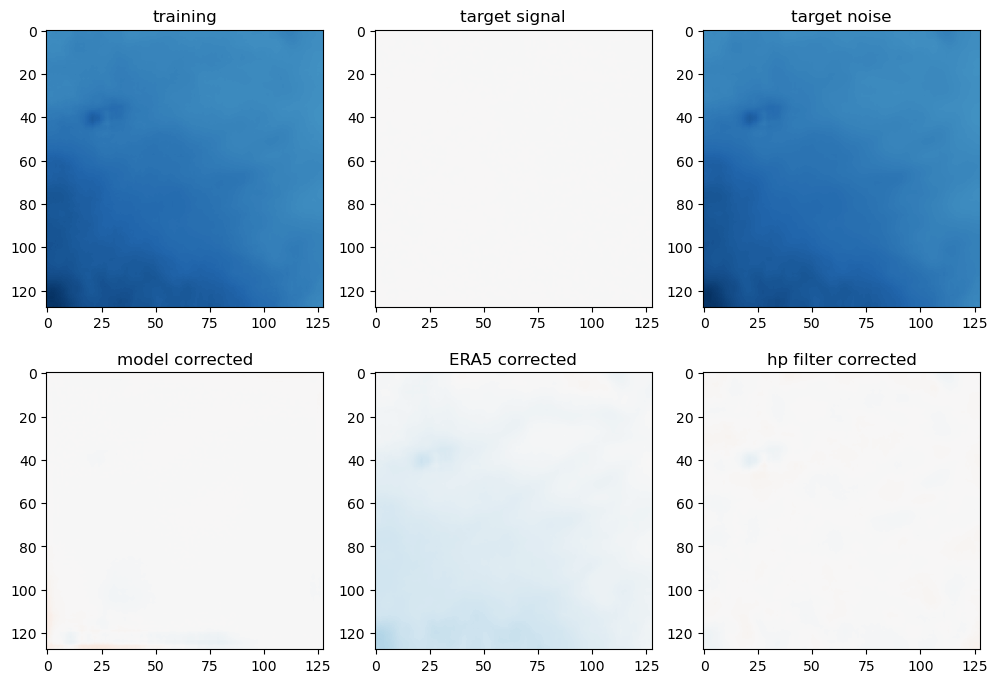

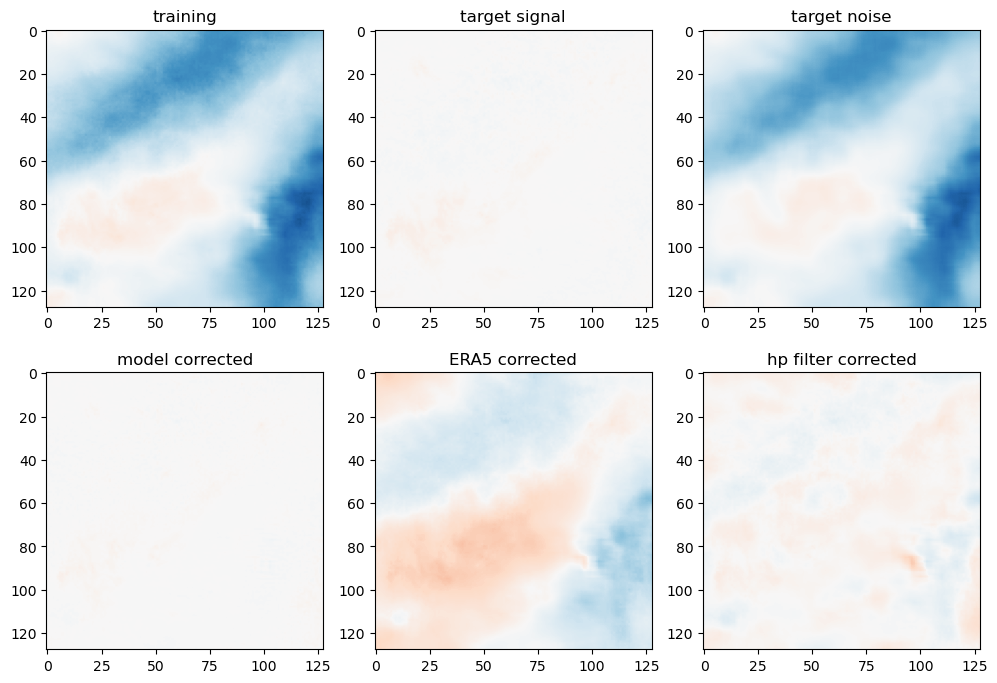

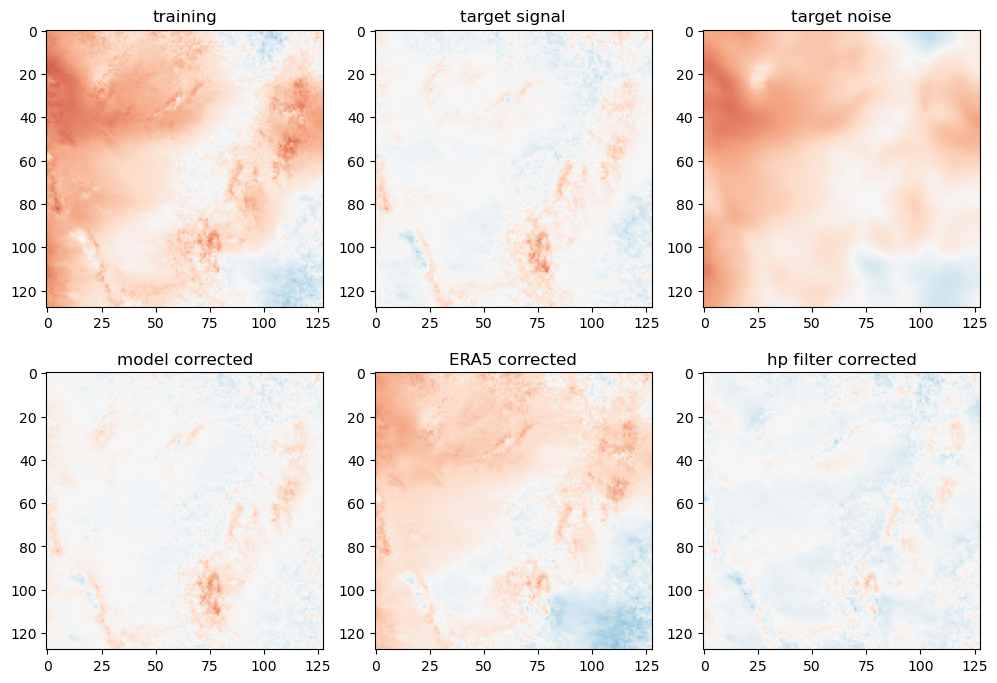

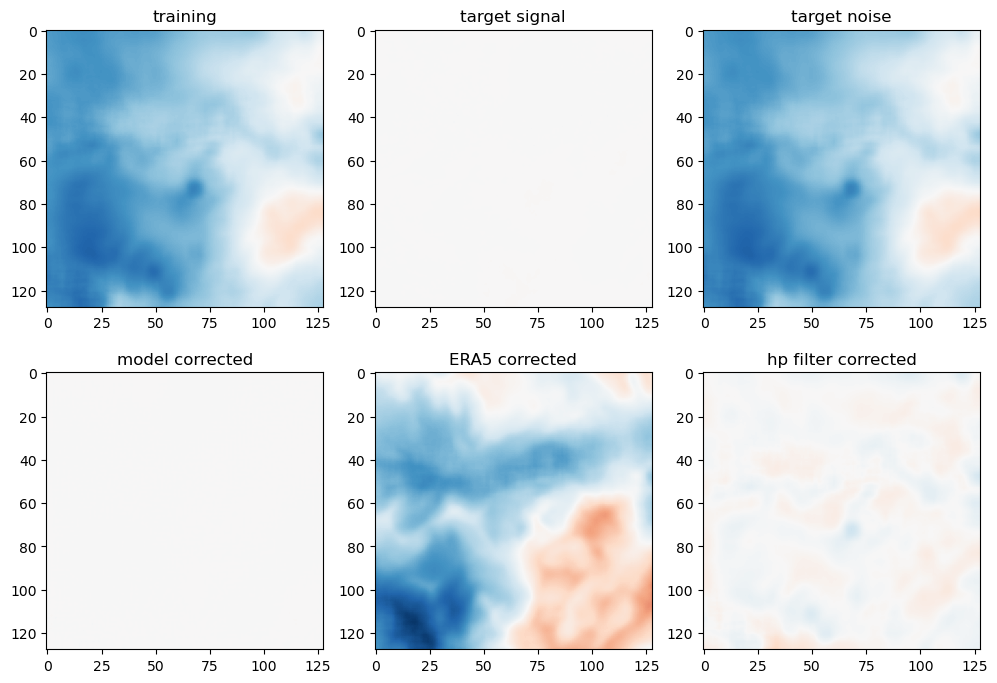

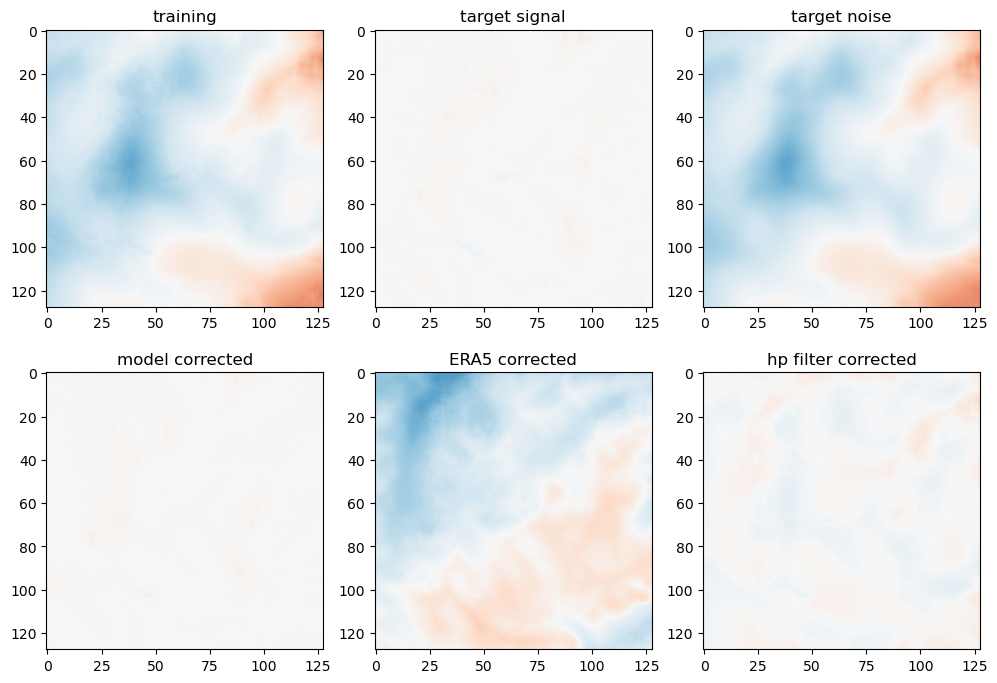

In [12]:
# examine corrections
num_images = 5

for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(val_loader_ssim):
    if i < num_images:
            noise_pred = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
            signal_pred = torch.clamp(sample.to('cpu') - noise_pred.to('cpu'), -1, 1)
            f, ax = plt.subplots(2, 3, figsize=(10,7))
            ax[0, 0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2) 
            ax[0, 0].set_title('training')
            ax[0, 1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0, 1].set_title('target signal')
            ax[0, 2].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0, 2].set_title('target noise')
            
            ax[1, 0].imshow(signal_pred.detach().squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 0].set_title('model corrected')
            ax[1, 1].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 1].set_title('ERA5 corrected')
            ax[1, 2].imshow(hp_corr.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 2].set_title('hp filter corrected')
            f.tight_layout()

In [9]:
def ssim_lists(model, data_loader):
    # Calculate val SSIM 
    ssim_list_uncorrected = []
    ssim_list_model_corrected = []
    ssim_list_era5_corrected = []
    ssim_list_hp_corrected = []
    
    for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(data_loader):
        # uncorrected SSIM
        ssim_value_uncorrected = ssim(sample.squeeze().detach().numpy(), signal_target.squeeze().detach().numpy(),
                         gaussian_weights=True)
        ssim_list_uncorrected.append(ssim_value_uncorrected)
    
        # model corrected SSIM
        noise = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
        signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1)
        ssim_value_model_corrected = ssim(signal.squeeze().detach().numpy(), signal_target.squeeze().detach().numpy(),
                         gaussian_weights=True)
        ssim_list_model_corrected.append(ssim_value_model_corrected)
    
        # era5 corrected SSIM
        ssim_value_era5_corrected = ssim(era5_corr.squeeze().numpy(), signal_target.squeeze().numpy(),
                         gaussian_weights=True)
        ssim_list_era5_corrected.append(ssim_value_era5_corrected)
    
        # hp filter corrected SSIM
        ssim_value_hp_corrected = ssim(hp_corr.squeeze().numpy(), signal_target.squeeze().numpy(),
                         gaussian_weights=True)
        ssim_list_hp_corrected.append(ssim_value_hp_corrected)
    
    
    print('median ssim before correction:', np.median(ssim_list_uncorrected),
          '\nmedian ssim model correction:', np.median(ssim_list_model_corrected), 
          '\nmedian ssim era5 correction:', np.median(ssim_list_era5_corrected),
          '\nmedian ssim high pass filter correction:', np.median(ssim_list_hp_corrected))
    
    return ssim_list_uncorrected, ssim_list_model_corrected, ssim_list_era5_corrected, ssim_list_hp_corrected

In [10]:
print('val data ssim')
val_ssim_list_uncorrected, val_ssim_list_model, val_ssim_list_era5, val_ssim_list_hp = ssim_lists(model, val_loader_ssim)
print('training data ssim')
train_ssim_list_uncorrected, train_ssim_list_model, train_ssim_list_era5, train_ssim_list_hp = ssim_lists(model, train_loader_ssim)

val data ssim
median ssim before correction: 0.000927597777060747 
median ssim model correction: 0.6883844852426464 
median ssim era5 correction: 0.09782191103626094 
median ssim high pass filter correction: 0.3280624854370918
training data ssim
median ssim before correction: 0.00232428341840885 
median ssim model correction: 0.933042921838661 
median ssim era5 correction: 0.09072675388686217 
median ssim high pass filter correction: 0.3167093921619908


In [11]:
# Calculate SNR
def rms(tensor):
    rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
    return rms

def snr(model, data_loader):
    snr_list = []

    for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(data_loader):
        snr_list.append(rms(signal_target)/rms(sample-signal_target))

    print('median snr of images:', np.median(snr_list), 'stdev of SNR of images:', np.std(snr_list))
    
    return snr_list

In [12]:
val_snr_list = snr(model, val_loader_ssim)
train_snr_list = snr(model, train_loader_ssim)

median snr of images: 0.032663956 stdev of SNR of images: 0.7170849
median snr of images: 0.03388098 stdev of SNR of images: 0.7964427


In [13]:
def df_for_plotting(snr_list, ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_hp):

    roll_count = 200
    q_low = 25
    q_high = 75

    ssim_dict = {'snr': snr_list,
                     'ssim_uncorrected':ssim_list_uncorrected,
                     'ssim_model':ssim_list_model,
                     'ssim_era5':ssim_list_era5, 
                     'ssim_hp':ssim_list_hp}
    ssim_df = pd.DataFrame(ssim_dict)

    # uncorrected ssim
    ssim_df['ssim_uncorrected_median'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_uncorrected_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_uncorrected_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # model corrected ssim
    ssim_df['ssim_model_median'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_model_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_model_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_era5_median'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_era5_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_era5_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_hp_median'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_hp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_hp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_high/100)
    
    return ssim_df

In [14]:
val_ssim_df=df_for_plotting(val_snr_list, val_ssim_list_uncorrected, val_ssim_list_model, val_ssim_list_era5, val_ssim_list_hp)
train_ssim_df=df_for_plotting(train_snr_list, train_ssim_list_uncorrected, train_ssim_list_model, train_ssim_list_era5, train_ssim_list_hp)

In [15]:
# can't plot exactly 0 snr due to log scale
train_ssim_df = train_ssim_df[train_ssim_df.snr != 0]

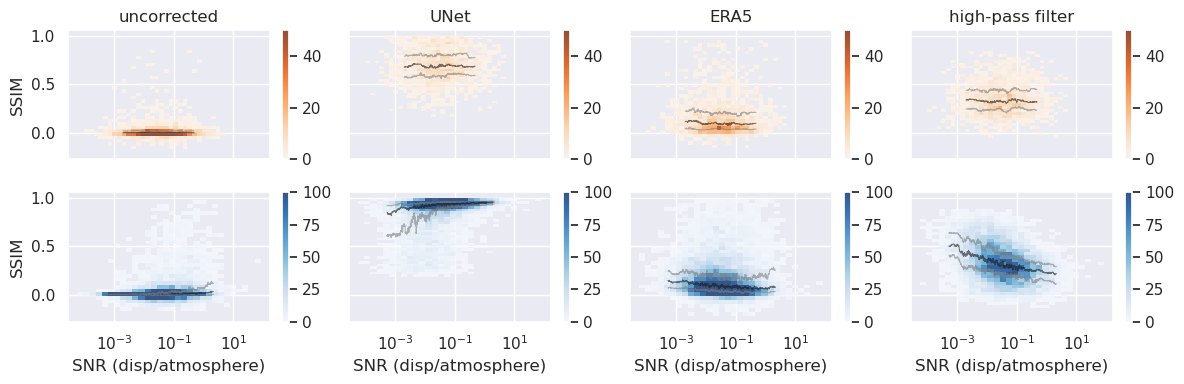

In [20]:
sns.set_theme()

f, ax = plt.subplots(2, 4, figsize=(12,4), sharex=True, sharey=True)

# val uncorrected 
sns.histplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0, 0].set_xscale('log')

sns.histplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel('SSIM')
ax[0, 0].set_title('uncorrected')

sns.lineplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df.snr, y=val_ssim_df.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# val model corrected
sns.histplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_model, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0, 1].set_xscale('log')
ax[0, 1].set_ylabel('SSIM')
ax[0, 1].set_title('UNet')

sns.lineplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_model_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df.snr, y=val_ssim_df.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# val era5 corrected
sns.histplot(ax=ax[0, 2], x=val_ssim_df.snr, y=val_ssim_df.ssim_era5, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0, 2].set_xscale('log')
ax[0, 2].set_ylabel('SSIM')
ax[0, 2].set_title('ERA5')

sns.lineplot(ax=ax[0, 2], x=val_ssim_df.snr, y=val_ssim_df.ssim_era5_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_ssim_df.snr, y=val_ssim_df.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_ssim_df.snr, y=val_ssim_df.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# val hp corrected
sns.histplot(ax=ax[0, 3], x=val_ssim_df.snr, y=val_ssim_df.ssim_hp, cmap='Oranges', cbar=True,
             bins=30, vmax=50, alpha=0.8)
ax[0, 3].set_xscale('log')
ax[0, 3].set_xlabel('SNR (disp/atmosphere)')
ax[0, 3].set_ylabel('SSIM')
ax[0, 3].set_title('high-pass filter')

sns.lineplot(ax=ax[0, 3], x=val_ssim_df.snr, y=val_ssim_df.ssim_hp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_ssim_df.snr, y=val_ssim_df.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_ssim_df.snr, y=val_ssim_df.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train uncorrected 
sns.histplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel('SSIM')
ax[1, 0].set_xlabel('SNR (disp/atmosphere)')

sns.lineplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df.snr, y=train_ssim_df.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# train model corrected
sns.histplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_model, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('SNR (disp/atmosphere)')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_model_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df.snr, y=train_ssim_df.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# train era5 corrected
sns.histplot(ax=ax[1, 2], x=train_ssim_df.snr, y=train_ssim_df.ssim_era5, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_xlabel('SNR (disp/atmosphere)')
f.tight_layout()

sns.lineplot(ax=ax[1, 2], x=train_ssim_df.snr, y=train_ssim_df.ssim_era5_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_ssim_df.snr, y=train_ssim_df.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_ssim_df.snr, y=train_ssim_df.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# train hp corrected
sns.histplot(ax=ax[1, 3], x=train_ssim_df.snr, y=train_ssim_df.ssim_hp, cmap='Blues', cbar=True, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 3].set_xscale('log')
ax[1, 3].set_xlabel('SNR (disp/atmosphere)')
f.tight_layout()

sns.lineplot(ax=ax[1, 3], x=train_ssim_df.snr, y=train_ssim_df.ssim_hp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_ssim_df.snr, y=train_ssim_df.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_ssim_df.snr, y=train_ssim_df.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)


plt.savefig('SSIMv1.png', dpi=300)

In [21]:
# violin plots 
ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_hp']
val_ssim_long = pd.melt(val_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
val_ssim_long['dataset'] = 'val'

ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_hp']
train_ssim_long = pd.melt(train_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
train_ssim_long['dataset'] = 'train'

all_ssim_long = pd.concat([train_ssim_long, val_ssim_long])

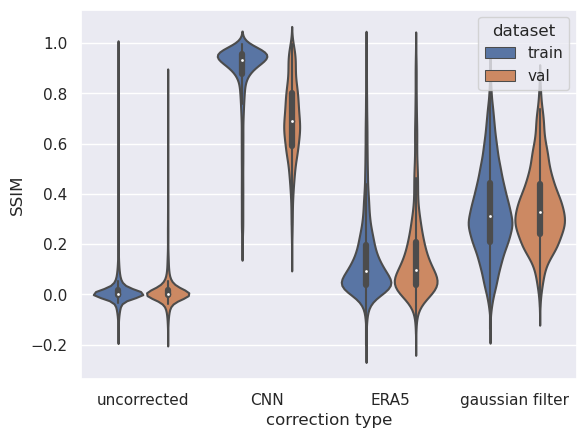

In [22]:
f, ax = plt.subplots()
sns.violinplot(ax=ax, data=all_ssim_long, x="corr_type", y="ssim", hue='dataset')
ax.set_xticklabels(['uncorrected', 'CNN', 'ERA5', 'gaussian filter'])
ax.set_xlabel('correction type')
ax.set_ylabel('SSIM')
plt.savefig('SSIM_violin.png', dpi=300)

In [ ]:
#histplots 
f, ax = plt.subplots(1, 2, figsize=(8,3))
sns.kdeplot(ax=ax[1], data=val_ssim_long, x='ssim', hue='corr_type', hue_order=['ssim_hp', 'ssim_era5', 'ssim_model', 'ssim_uncorrected'], palette=['peru', 'orange', 'blue', 'red'], fill=True, legend=False)
sns.kdeplot(ax=ax[0], data=train_ssim_long, x='ssim', hue='corr_type', hue_order=['ssim_hp', 'ssim_era5', 'ssim_model', 'ssim_uncorrected'], palette=['peru', 'orange', 'blue', 'red'], fill=True, legend=False)
ax[1].set_xlim((-0.25, 1.15))
ax[0].set_xlim((-0.25, 1.15))
ax[1].set_xlabel('SSIM')
ax[0].set_xlabel('SSIM')
ax[1].set_ylabel('kernel density')
ax[0].set_ylabel('kernel density')
f.tight_layout()
plt.savefig('ssim_kde.png', dpi=300)

In [ ]:
#example corrections for paper fig
plt.style.use('default')

num_images = 1

for i, (sample, signal_target, noise_target, era5_noise, dem, era5_corr, hp_corr) in enumerate(val_loader_ssim):
    if i < num_images:
            noise_pred = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
            signal_pred = torch.clamp(sample.to('cpu') - noise_pred.to('cpu'), -1, 1)
            f, ax = plt.subplots(2, 4, figsize=(10,6))
            ax[0, 0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2) 
            ax[0, 0].set_title('training')
            ax[0, 0].axis('off')
            
            ax[0, 1].imshow(dem.squeeze(), cmap='Greys_r', vmin=-1, vmax=1) 
            ax[0, 1].set_title('DEM')
            ax[0, 1].axis('off')
            
            ax[0, 2].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0, 2].set_title('target signal')
            ax[0, 2].axis('off')
            
            ax[0, 3].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0, 3].set_title('target noise')
            ax[0, 3].axis('off')
            
            ax[1, 0].imshow(noise_pred.detach().squeeze().to('cpu'), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 0].set_title('model noise prediction')
            ax[1, 0].axis('off')
            
            ax[1, 1].imshow(signal_pred.detach().squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 1].set_title('model corrected')
            ax[1, 1].axis('off')
            
            ax[1, 2].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 2].set_title('ERA5 corrected')
            ax[1, 2].axis('off')
            
            ax[1, 3].imshow(hp_corr.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1, 3].set_title('hp filter corrected')
            ax[1, 3].axis('off')
            
            f.tight_layout()
            
            plt.savefig('pred_example.png', dpi=300)

### Stats

In [34]:
train_ssim_df

snr  ssim_uncorrected  ssim_model  ssim_era5   ssim_hp  \
0      0.193611          0.052875    0.971400   0.026864  0.291440   
1      0.005355          0.000465    0.329973   0.195504  0.675133   
2      0.006955          0.000838    0.280698   0.223370  0.649125   
3      0.006548          0.010651    0.891865   0.159167  0.436261   
4      0.109439          0.049891    0.960296  -0.138277  0.117385   
...         ...               ...         ...        ...       ...   
11210  0.043469          0.004070    0.827455   0.134601  0.254843   
11211  0.053566          0.296944    0.958790   0.499705  0.155646   
11212  0.062412          0.052018    0.926759  -0.038391 -0.025637   
11213  0.012998          0.309987    0.952449   0.355903  0.268074   
11214  0.080933         -0.007142    0.940495  -0.026730  0.134445   

       ssim_uncorrected_median  ssim_uncorrected_q25  ssim_uncorrected_q75  \
0                     0.005385             -0.004704              0.036528   
1                     0.000743             -0.001677              0.008443   
2                     0.001280             -0.001817              0.008968   
3                     0.001345             -0.001790              0.008014   
4                     0.006433             -0.002710              0.035032   
...                        ...                   ...                   ...   
11210                 0.004415             -0.000860              0.022566   
11211                 0.001358             -0.004733              0.013729   
11212                 0.003679             -0.002683              0.021292   
11213                 0.001961             -0.001694              0.009439   
11214                 0.004320             -0.002270              0.034876   

       ssim_model_median  ssim_model_q25  ssim_model_q75  ssim_era5_median  \
0               0.946564        0.924347        0.964778          0.075056   
1               0.906788        0.738186        0.942220          0.114120   
2               0.906637        0.831939        0.944329          0.110658   
3               0.910539        0.821679        0.947178          0.112506   
4               0.944622        0.916024        0.961306          0.094477   
...                  ...             ...             ...               ...   
11210           0.937390        0.886648        0.962508          0.077384   
11211           0.930606        0.873322        0.959274          0.084301   
11212           0.937276        0.895933        0.958873          0.075420   
11213           0.925299        0.817002        0.952788          0.086927   
11214           0.940452        0.905244        0.960034          0.089777   

       ssim_era5_q25  ssim_era5_q75  ssim_hp_median  ssim_hp_q25  ssim_hp_q75  
0           0.025999       0.172140        0.252848     0.167927     0.342425  
1           0.048844       0.192773        0.378155     0.259615     0.532602  
2           0.049112       0.181256        0.385017     0.259062     0.475494  
3           0.051274       0.206243        0.383558     0.241861     0.488366  
4           0.036703       0.218766        0.268856     0.170373     0.385708  
...              ...            ...             ...          ...          ...  
11210       0.036739       0.165326        0.295256     0.209372     0.385323  
11211       0.035042       0.168791        0.280598     0.187146     0.423530  
11212       0.032542       0.149000        0.295671     0.207716     0.410406  
11213       0.041228       0.216438        0.367214     0.241593     0.508462  
11214       0.032636       0.215649        0.296525     0.209288     0.398317  

[11215 rows x 17 columns]

In [32]:
np.median(train_ssim_df['ssim_hp'])
#np.std(val_ssim_df['ssim_hp'])

0.144891045665258

In [40]:
def nmad_scalar(array, sample_percent, iterations):
    """
    https://stats.stackexchange.com/questions/355943/how-to-estimate-the-scale-factor-for-mad-for-a-non-normal-distribution
    """
    length = len(array)
    sample_num = math.floor(length*(sample_percent/100))
    scalars = []
    for i in range(iterations):
        samples = []
        for j in range(sample_num):
            samples.append(array[random.randint(0, length-1)])
        scalar = np.std(samples)/stats.median_abs_deviation(samples, scale=1)
        scalars.append(scalar)
    return np.mean(scalars)

In [88]:
train_ssim_df

snr  ssim_uncorrected  ssim_model  ssim_era5   ssim_hp  \
0      0.273814          0.156002    0.932190   0.033432  0.162105   
1      0.001569          0.000617    0.335431   0.196999  0.672060   
2      0.225118          0.001036    0.289064   0.226619  0.636865   
3      0.153819          0.006766    0.882252   0.126635  0.411504   
4      0.020868          0.018322    0.896622   0.037946  0.209554   
...         ...               ...         ...        ...       ...   
11210  0.057782          0.013218    0.966639   0.319327  0.025389   
11211  0.382104          0.029055    0.969703   0.150775  0.306906   
11212  0.036192          0.017612    0.909057   0.030058  0.257255   
11213  0.385621          0.211010    0.957283   0.229373  0.287121   
11214  0.010825          0.060604    0.973251   0.516960  0.062412   

       ssim_uncorrected_median  ssim_uncorrected_q25  ssim_uncorrected_q75  \
0                     0.008644             -0.003136              0.056146   
1                     0.000884             -0.001207              0.004391   
2                     0.008786             -0.000028              0.039159   
3                     0.006674             -0.005339              0.043848   
4                     0.000668             -0.004349              0.010535   
...                        ...                   ...                   ...   
11210                 0.001451             -0.004969              0.018878   
11211                 0.009973             -0.002852              0.044852   
11212                 0.002800             -0.000369              0.022494   
11213                 0.010583             -0.002547              0.045339   
11214                 0.002429             -0.000181              0.009231   

       ssim_model_median  ssim_model_q25  ssim_model_q75  ssim_era5_median  \
0               0.945116        0.917470        0.961592          0.077066   
1               0.863753        0.551139        0.929254          0.175681   
2               0.946046        0.908732        0.961853          0.079284   
3               0.947704        0.919077        0.965846          0.069513   
4               0.935875        0.871211        0.956899          0.112824   
...                  ...             ...             ...               ...   
11210           0.936135        0.903940        0.956597          0.091255   
11211           0.950263        0.927978        0.965611          0.063030   
11212           0.936264        0.858266        0.960221          0.096985   
11213           0.951593        0.928250        0.966327          0.064247   
11214           0.917931        0.831099        0.952485          0.105655   

       ssim_era5_q25  ssim_era5_q75  ssim_hp_median  ssim_hp_q25  ssim_hp_q75  
0           0.020476       0.184996        0.277242     0.177747     0.370784  
1           0.069705       0.256595        0.470267     0.325639     0.600786  
2           0.034516       0.162878        0.287946     0.184473     0.372494  
3           0.029550       0.151202        0.265311     0.183367     0.358639  
4           0.040164       0.205636        0.329571     0.226870     0.451948  
...              ...            ...             ...          ...          ...  
11210       0.043147       0.183675        0.302070     0.220448     0.400616  
11211       0.024381       0.182946        0.250693     0.150768     0.324285  
11212       0.042875       0.221370        0.317905     0.228458     0.447067  
11213       0.025318       0.186193        0.245139     0.142508     0.312742  
11214       0.050909       0.209751        0.384318     0.255093     0.512438  

[11215 rows x 17 columns]

In [111]:
scalar = nmad_scalar(train_ssim_df['ssim_hp'], 10, 50)
nmad = stats.median_abs_deviation(train_ssim_df['ssim_hp'], scale=scalar)
median = np.median(train_ssim_df['ssim_hp'])
print('median = ', median, ', nmad = ', nmad)

median =  0.3167093921619908 , nmad =  0.07247858570297701


In [112]:
scalar

1.578367797153438

In [26]:
# test if data are normally distributed
print('val uncorrected: ', stats.kstest(train_ssim_df['ssim_uncorrected'].values, stats.norm.cdf))
print('val model: ', stats.kstest(train_ssim_df['ssim_model'].values, stats.norm.cdf))
print('val era5: ', stats.kstest(train_ssim_df['ssim_era5'].values, stats.norm.cdf))
print('val hp: ', stats.kstest(train_ssim_df['ssim_hp'].values, stats.norm.cdf))

#they are not even close to normal

val uncorrected:  KstestResult(statistic=0.4558999588281651, pvalue=0.0)
val model:  KstestResult(statistic=0.6406662052333103, pvalue=0.0)
val era5:  KstestResult(statistic=0.4661828428012287, pvalue=0.0)
val hp:  KstestResult(statistic=0.48432301975025316, pvalue=0.0)


In [29]:
# wilcoxon signed rank test to compare paired samples
stats.wilcoxon(val_ssim_df['ssim_uncorrected'].values, val_ssim_df['ssim_model'].values, nan_policy='omit')

WilcoxonResult(statistic=369.0, pvalue=1.083667503073083e-279)

In [30]:
stats.wilcoxon(val_ssim_df['ssim_model'].values, val_ssim_df['ssim_era5'].values, nan_policy='omit')

WilcoxonResult(statistic=9411.0, pvalue=8.04101745853449e-273)

In [31]:
stats.wilcoxon(val_ssim_df['ssim_model'].values, val_ssim_df['ssim_hp'].values, nan_policy='omit')

WilcoxonResult(statistic=49640.0, pvalue=2.694854637516467e-243)

## Visualize feature maps

In [ ]:
# visualize feature maps

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cnn_names = ['cnn1', 'cnn2', 'cnn3','cnn4','cnn5', 'cnn6', 'cnn7', 'cnn8'] 
cnn_vars = [model.cnn1, model.cnn2, model.cnn3, model.cnn4, model.cnn5,
            model.cnn6, model.cnn7, model.cnn8]


def plot_feature(cnn_vars, cnn_names, num_images=1):
    for i, (sample, signal_target, noise_target, dem) in enumerate(val_loader):
        if i<num_images:
            for j, cnn_name in enumerate(cnn_names):
                cnn = cnn_vars[j]
                cnn.register_forward_hook(get_activation(cnn_name))
                output = model(sample.to('cuda'), dem.to('cuda'))

                act = activation[cnn_name].squeeze()
                act1 = act[0:15,:,:].sum(dim=0, keepdim=True).squeeze()
                act2 = act[16:31,:,:].sum(dim=0, keepdim=True).squeeze()
                act3 = act[32:47,:,:].sum(dim=0, keepdim=True).squeeze()
                act4 = act[48:63,:,:].sum(dim=0, keepdim=True).squeeze()

                fig, ax = plt.subplots(1, 5, figsize=(19,5))
                #ax[0].imshow(dem.squeeze().to('cpu'), cmap='Greys')
                ax[0].imshow(sample.squeeze().to('cpu'), cmap='RdBu')
                ax[0].set_title('original image')
                ax[1].imshow(act1.to('cpu'))
                ax[1].set_title(f'{cnn_name} feature map')
                ax[2].imshow(act2.to('cpu'))
                ax[2].set_title(f'{cnn_name} feature map')
                ax[3].imshow(act3.to('cpu'))
                ax[3].set_title(f'{cnn_name} feature map')
                ax[4].imshow(act4.to('cpu'))
                ax[4].set_title(f'{cnn_name} feature map')
        else:
            break
            
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True)

In [ ]:
plot_feature(cnn_vars, cnn_names, num_images=1)